In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import matrix_normalization, convert_states_str2int, \
    normalize_state, normalize_weights, get_null_p, get_fdr_p
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

# Protocol Pathway A, variant: Non-binary brain states

### Load A

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/nctpy/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/nctpy/results'
A_file = 'pnc_schaefer200_Am.npy'
rsts_file = 'pnc_schaefer200_rsts.npy'

In [3]:
# load A matrix
A = np.load(os.path.join(datadir, A_file))
n_nodes = A.shape[0]
print(A.shape)

(200, 200)


### Normalize A

In [4]:
# normalize
system = 'continuous'
A_norm = matrix_normalization(A, system=system, c=1)

### Cluster fMRI data

In [5]:
# load resting-state time series
rsts = np.load(os.path.join(datadir, rsts_file))

n_trs = rsts.shape[0]
n_nodes_rsts = rsts.shape[1]
n_subs = rsts.shape[2]
print('n_trs, {0}; n_nodes, {1}; n_subs, {2}'.format(n_trs, n_nodes_rsts, n_subs))

rsts_concat = np.zeros((n_trs * n_subs, n_nodes_rsts))
print(rsts_concat.shape)

for i in np.arange(n_subs):
    # z score subject i's time series
    rsts_z = sp.stats.zscore(rsts[:, :, i], axis=0)

    start_idx = i * n_trs
    end_idx = start_idx + n_trs
    rsts_concat[start_idx:end_idx, :] = rsts_z

n_trs, 120; n_nodes, 200; n_subs, 253
(30360, 200)


(5, 200)


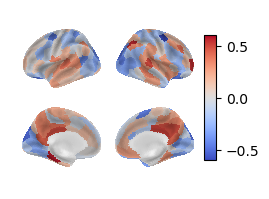

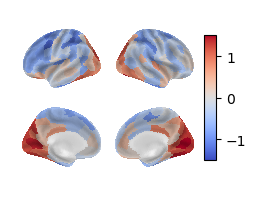

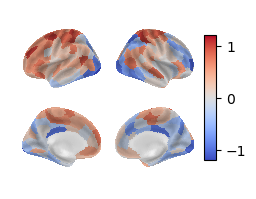

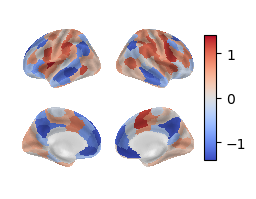

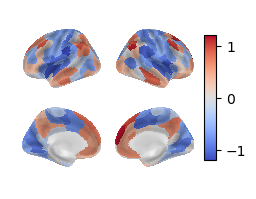

In [6]:
# extract 5 clusters of activity
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rsts_concat)

# extract cluster centers. These represent dominant patterns of recurrent activity over time
centroids = kmeans.cluster_centers_
print(centroids.shape)

# plot centroids on brain surface
lh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                'fsaverage5/lh.Schaefer2018_200Parcels_7Networks_order.annot'
rh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                'fsaverage5/rh.Schaefer2018_200Parcels_7Networks_order.annot'
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')

for i in np.arange(n_clusters):
    f = surface_plot(data=centroids[i, :],
                     lh_annot_file=lh_annot_file, rh_annot_file=rh_annot_file,
                     fsaverage=fsaverage, order='lr', cmap='coolwarm')
    f.savefig(os.path.join(resultsdir, 'cluster_{0}.png'.format(i)), dpi=600, bbox_inches='tight', pad_inches=0.01)

### Get initial and target state

In [7]:
# extract visual cluster is initial state
x0 = centroids[1, :]
# extract default mode cluster as target state
xf = centroids[4, :]

In [8]:
# normalize state magnitude
x0 = normalize_state(x0)
xf = normalize_state(xf)

### Setup control nodes and weights

In [9]:
# specify a uniform full control set: all nodes are control nodes
# and all control nodes are assigned equal control weight
B = np.eye(n_nodes)

In [10]:
# set parameters
T = 1 # time horizon
rho = 1 # mixing parameter for state trajectory constraint
S = np.eye(n_nodes) # nodes in state trajectory to be constrained

# get the state trajectory (x) and the control inputs (u)
x, u, n_err = get_control_inputs(A_norm=A_norm, T=T, B=B, x0=x0, xf=xf,
                                 system=system, rho=rho, S=S)

### Plot x and u

[   0  200  400  600  800 1000]


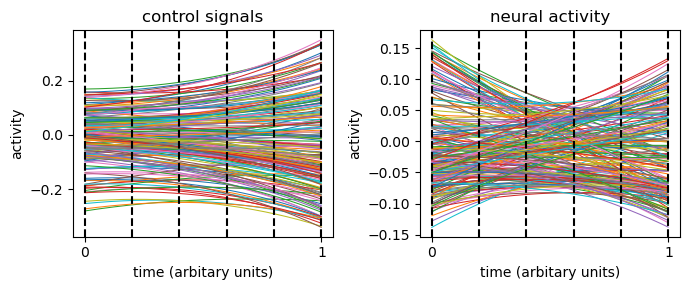

In [11]:
timepoints_to_plot = np.arange(0, x.shape[0], int(x.shape[0]/5))
print(timepoints_to_plot)

f, ax = plt.subplots(1, 2, figsize=(7, 3))
# plot control signals for initial state
ax[0].plot(u, linewidth=0.75)
ax[0].set_title('control signals')

# plot state trajectory for initial state
ax[1].plot(x, linewidth=0.75)
ax[1].set_title('neural activity')

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (arbitary units)")
    cax.set_xticks([0, x.shape[0]])
    cax.set_xticklabels([0, T])

    for i in timepoints_to_plot:
        cax.axvline(x=i, color='black', linestyle='--')

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'plot_xu_fmri.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

### Compute control energy

In [12]:
# integrate control inputs to get control energy
node_energy = integrate_u(u)

# summarize nodal energy
energy = np.sum(node_energy)

print(energy)

2676.107391658496


### Plot x and u on cortical surface

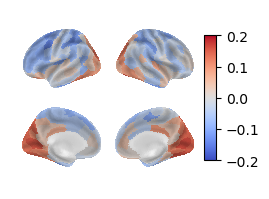

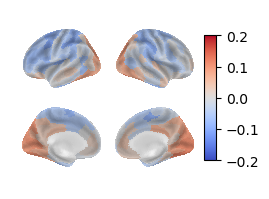

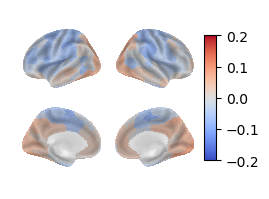

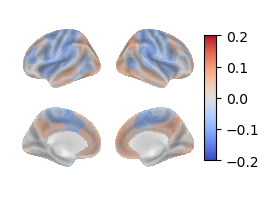

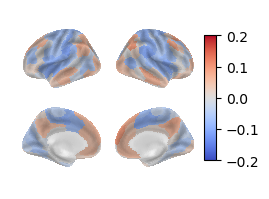

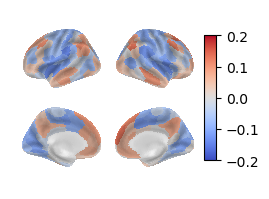

In [13]:
plot_u = False  # False for plotting x, True for plotting u

for i in timepoints_to_plot:
    if plot_u:
        data = u[i, :]
        vmax = 0.3
        vmin = -0.3
        fig_label = 'u_t{0}.png'.format(i)
    else:
        data = x[i, :]
        vmax = 0.2
        vmin = -0.2
        fig_label = 'x_t{0}.png'.format(i)

    f = surface_plot(data=data,
                     lh_annot_file=lh_annot_file, rh_annot_file=rh_annot_file,
                     fsaverage=fsaverage, order='lr',
                     cmap='coolwarm', cblim=[vmax, vmin])
    f.savefig(os.path.join(resultsdir, fig_label), dpi=600, bbox_inches='tight', pad_inches=0.01)

## Null network models

In [14]:
# null networks
spatial_centroids = pd.read_csv(os.path.join(datadir, 'pnc_schaefer200_centroids.csv'))  # load coordinates of nodes
spatial_centroids.set_index('node_names', inplace=True)
print(spatial_centroids.head())

D = distance.pdist(spatial_centroids, 'euclidean')  # get euclidean distances between nodes
D = distance.squareform(D)  # reshape to square matrix

            vox_x  vox_y  vox_z
node_names                     
LH_Vis_1      121    149     69
LH_Vis_2      123    174     65
LH_Vis_3      143    166     70
LH_Vis_4      107    164     74
LH_Vis_5      124    192     66


In [15]:
run = False
if run:
    # extract visual cluster is initial state
    x0 = centroids[1, :]
    # extract default mode cluster as target state
    xf = centroids[4, :]

    x0 = normalize_state(x0)  # normalize
    xf = normalize_state(xf)  # normalize

    # get true control energy
    _, u, _ = get_control_inputs(A_norm=A_norm, T=T, B=B, x0=x0, xf=xf,
                                 system=system, rho=rho, S=S)  # get u
    E = integrate_u(u)  # integrate u
    E = np.sum(E)  # get energy

    # run permutation
    n_perms = 5000  # number of permutations

    # containers for null distributions
    energy_null_sp = np.zeros(n_perms)
    energy_null_ssp = np.zeros(n_perms)

    for i in tqdm(np.arange(n_perms)):
        _, Wsp, Wssp = geomsurr(W=A, D=D, seed=i)  # rewire adjacency matrix using geomsurr
        # Wsp is A rewired while preserving spatial embedding and the strength distribution
        # Wssp is A rewired while preserving spatial embedding and the strength sequence
        # this python implementation is included with our toolbox, but if you use these nulls
        # in your own work, please cite:
        #       Roberts et al. NeuroImage (2016), doi:10.1016/j.neuroimage.2015.09.009

        Wsp = matrix_normalization(Wsp, system=system)  # normalize rewired adjacency matrix
        _, u, _ = get_control_inputs(A_norm=Wsp, T=T, B=B, x0=x0, xf=xf,
                                     system=system, rho=rho, S=S)  # get u
        e = integrate_u(u)  # integrate null u
        energy_null_sp[i] = np.sum(e)  # store null energy

        Wssp = matrix_normalization(Wssp, system=system)  # normalize rewired adjacency matrix
        _, u, _ = get_control_inputs(A_norm=Wssp, T=T, B=B, x0=x0, xf=xf,
                                     system=system, rho=rho, S=S)  # get u
        e = integrate_u(u)  # integrate null u
        energy_null_ssp[i] = np.sum(e)  # store null energy

In [16]:
run = False
if run:
    # plot
    f, ax = plt.subplots(1, 2, figsize=(7, 2))
    null_plot(observed=E, null=energy_null_sp,
              xlabel='energy null (space & str. dist.)', ax=ax[0])
    null_plot(observed=E, null=energy_null_ssp,
              xlabel='energy null (space & str. seq.)', ax=ax[1])
    f.tight_layout()
    f.savefig(os.path.join(resultsdir, 'energy_network_null.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plt.show()